In [1]:
!pip install thop scikit-learn


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, f1_score, precision_score, recall_score
from thop import profile, clever_format


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Dataset path
DATA_DIR = "/kaggle/input/saad-3/Microscopic Image Dataset of Plant-Parasitic Nematodes"

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)

# Split 80:20 Train:Test
test_ratio = 0.1
test_size = int(test_ratio * len(dataset))
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Split 10% of train as validation
val_ratio = 0.1
val_size = int(val_ratio * len(train_dataset))
train_size_final = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size_final, val_size])

# Dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Classes
classes = dataset.classes
num_classes = len(classes)
print(f"Classes: {classes}")
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Using device: cuda
Classes: ['Genus Criconema', 'Genus Criconemoides', 'Genus Helicotylenchus', 'Genus Hemicycliophora', 'Genus Hirschmaniella', 'Genus Hoplolaimus', 'Genus Meloidogyne', 'Genus Pratylenchus', 'Genus Radopholus', 'Genus Trichodorus', 'Genus Xiphinema']
Train: 824, Val: 91, Test: 101


In [4]:
# Load ViT-B16 pretrained
vit_model = models.vit_b_16(weights="IMAGENET1K_V1")

# Replace head
vit_model.heads.head = nn.Linear(vit_model.heads.head.in_features, num_classes)
vit_model = vit_model.to(device)

# GFLOPs & Params
dummy_input = torch.randn(1, 3, 224, 224).to(device)
flops, params = profile(vit_model, inputs=(dummy_input,), verbose=False)
flops, params = clever_format([flops, params], "%.3f")
print(f"GFLOPs: {flops}, Parameters: {params}")


GFLOPs: 11.285G, Parameters: 57.307M


In [5]:
dummy_input = torch.randn(1, 3, 224, 224).to(device)
flops, params = profile(vit_model, inputs=(dummy_input,), verbose=False)
flops, params = clever_format([flops, params], "%.3f")
print(f"GFLOPs: {flops}, Parameters: {params}")


GFLOPs: 11.285G, Parameters: 57.307M


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_model.parameters(), lr=1e-4)



In [7]:
num_epochs = 50

for epoch in range(num_epochs):
    vit_model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vit_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total

    # Validation
    vit_model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = vit_model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss /= val_total
    val_acc = val_correct / val_total

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch [1/50] Train Loss: 1.7370, Train Acc: 0.3835 | Val Loss: 1.3590, Val Acc: 0.5275
Epoch [2/50] Train Loss: 0.7300, Train Acc: 0.7549 | Val Loss: 0.7037, Val Acc: 0.7473
Epoch [3/50] Train Loss: 0.2200, Train Acc: 0.9369 | Val Loss: 0.6089, Val Acc: 0.7692
Epoch [4/50] Train Loss: 0.0983, Train Acc: 0.9745 | Val Loss: 0.7900, Val Acc: 0.8022
Epoch [5/50] Train Loss: 0.0855, Train Acc: 0.9794 | Val Loss: 0.5201, Val Acc: 0.8352
Epoch [6/50] Train Loss: 0.0455, Train Acc: 0.9915 | Val Loss: 0.5456, Val Acc: 0.7912
Epoch [7/50] Train Loss: 0.0288, Train Acc: 0.9927 | Val Loss: 0.6544, Val Acc: 0.7912
Epoch [8/50] Train Loss: 0.0098, Train Acc: 1.0000 | Val Loss: 0.5654, Val Acc: 0.8352
Epoch [9/50] Train Loss: 0.0030, Train Acc: 1.0000 | Val Loss: 0.5615, Val Acc: 0.8462
Epoch [10/50] Train Loss: 0.0020, Train Acc: 1.0000 | Val Loss: 0.5687, Val Acc: 0.8571
Epoch [11/50] Train Loss: 0.0017, Train Acc: 1.0000 | Val Loss: 0.5717, Val Acc: 0.8571
Epoch [12/50] Train Loss: 0.0015, Train A

In [10]:
all_labels = []
all_preds = []
all_probs = []

vit_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = vit_model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)


In [11]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-score: {f1:.4f}")

# Classification report with explicit labels
print("\nClassification Report:")
print(classification_report(
    all_labels,
    all_preds,
    labels=list(range(len(classes))),  # ensures all classes are included
    target_names=classes,
    zero_division=0
))


Test Accuracy: 0.8812
Test Precision: 0.8813
Test Recall: 0.8812
Test F1-score: 0.8773

Classification Report:
                       precision    recall  f1-score   support

      Genus Criconema       0.00      0.00      0.00         0
  Genus Criconemoides       0.92      0.92      0.92        13
Genus Helicotylenchus       1.00      1.00      1.00        16
Genus Hemicycliophora       0.00      0.00      0.00         1
 Genus Hirschmaniella       0.83      0.83      0.83        12
    Genus Hoplolaimus       0.95      0.90      0.92        20
    Genus Meloidogyne       0.84      0.94      0.89        17
   Genus Pratylenchus       0.62      0.83      0.71         6
     Genus Radopholus       1.00      0.60      0.75         5
    Genus Trichodorus       1.00      1.00      1.00         4
      Genus Xiphinema       0.71      0.71      0.71         7

            micro avg       0.88      0.88      0.88       101
            macro avg       0.72      0.70      0.70       101
     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


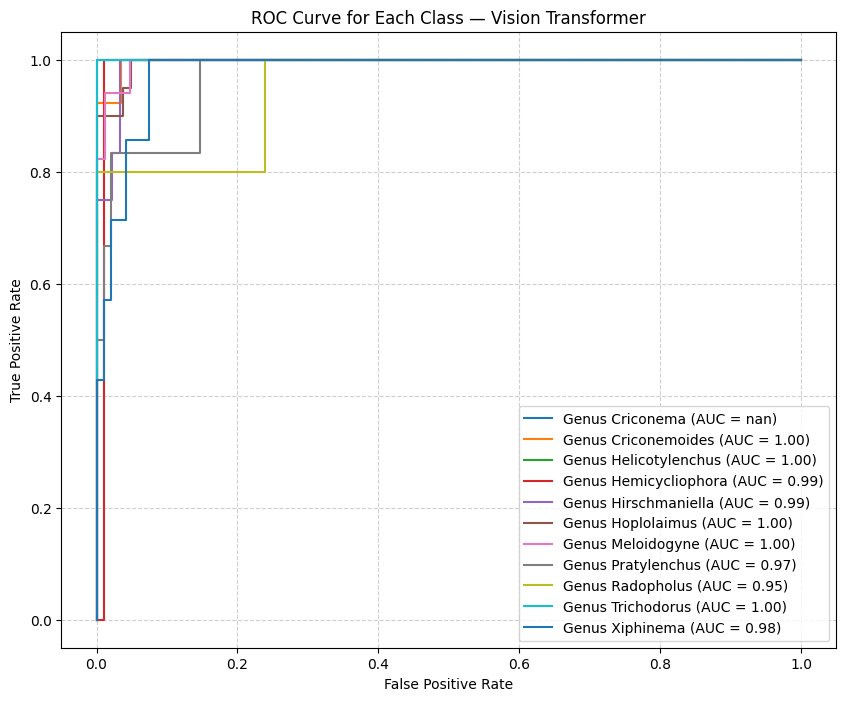

In [12]:
plt.figure(figsize=(10, 8))

for i, cls in enumerate(classes):
    binary_labels = (all_labels == i).astype(int)
    fpr, tpr, _ = roc_curve(binary_labels, all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} (AUC = {roc_auc:.2f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Class — Vision Transformer")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
